# Derks et al, 2024: Batch correction of single-cell MS proteomics data


In this tutorial, we will apply protVI to single-cell MS proteomics data containing bulk carrier channels. We will also use protVI's multi-level modelling capabilities.

We use the data from Derks et al. {cite}`Derks2024`, which contains protein abundances for THP-1 macrophage-like cells. Cells were stimulated with lipopolysaccharide for short durations (10, 30, or 60 minutes) or left untreated.

In [132]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
from scib_metrics.benchmark import Benchmarker
from sklearn.impute import KNNImputer

import protvi
import protvi.plots as pl
import protvi.utils

np.random.seed(0)
scvi.settings.seed = 0

sc.set_figure_params(figsize=(4, 4), frameon=False)

Seed set to 0


## Data loading

Let's start by loading the data, which can be found [here](https://drive.google.com/). The data has already been log-normalized.

In [134]:
adata = sc.read("../../data/processed/derks2024.h5ad")

## Data exploration

Let's look at the UMAPs of the raw data PCs.


In [135]:
sc.tl.pca(adata, n_comps=16)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

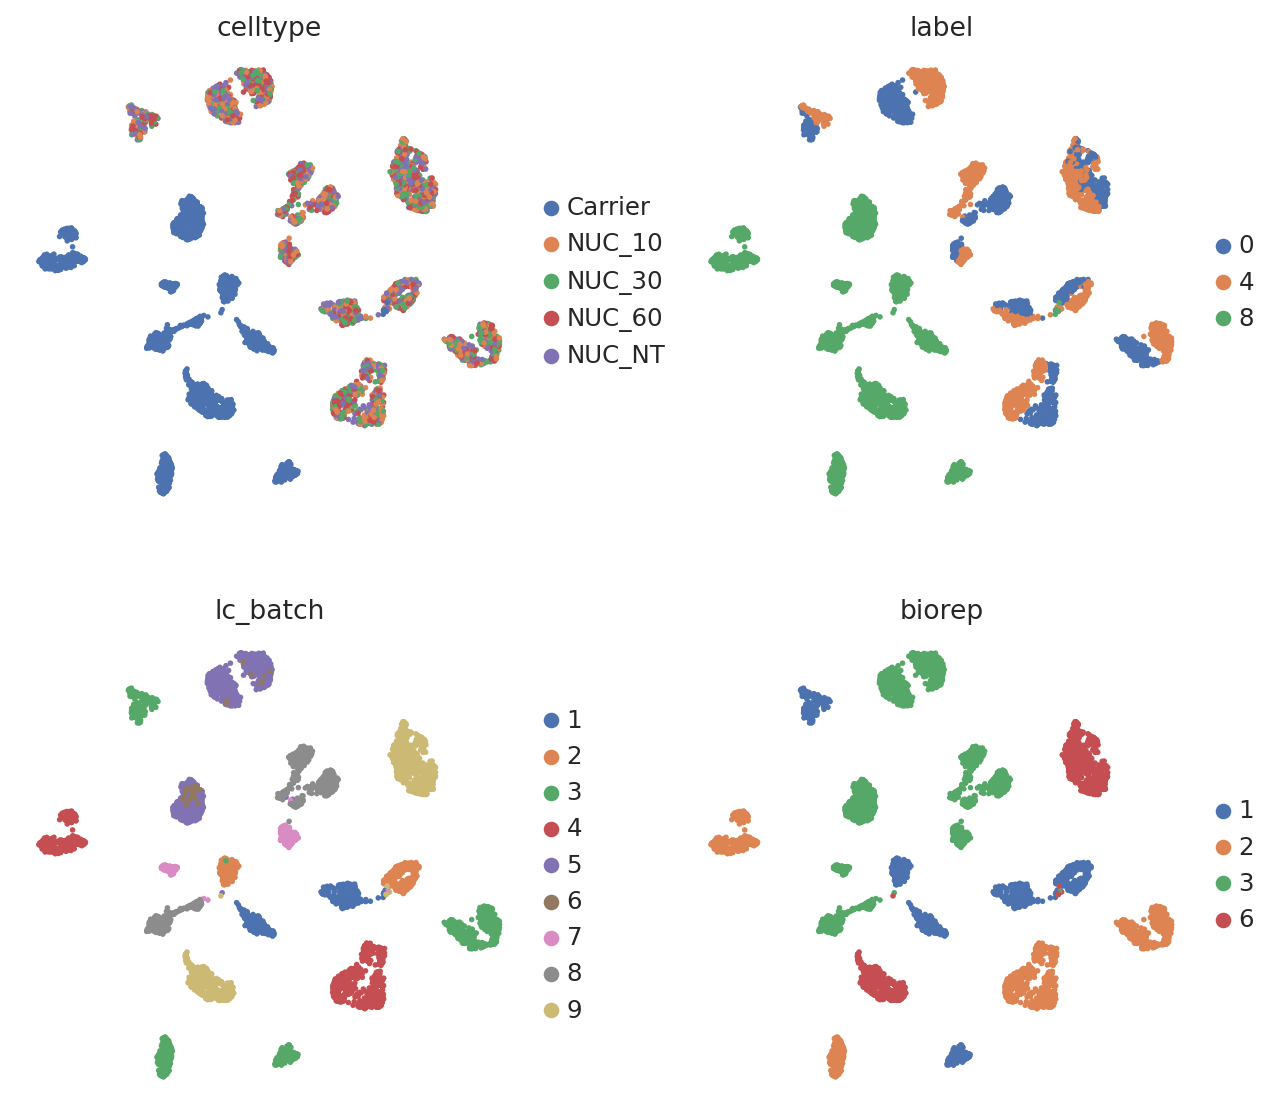

In [136]:
sc.pl.umap(
    adata,
    color=["celltype", "label", "lc_batch", "biorep"],
    vmin="p01",
    vmax="p99",
    ncols=2,
)

Notice samples cluster by whether they are single-cell or in the carrier channel. Within each of these two groups, samples cluster by batch. protVI will correct for these batch effects.


Let's only retain the single-cell data (including the booster channel as a covariate did not improve the latent representation).


In [137]:
adata = adata[~adata.obs.label.isin([8])].copy()

## Protein filtering


Let's filter out proteins that are detected in less than 20% of the cells - <font color='red'> as high abundance features are more likely to contribute to the representations. We will also filter out proteins with high coefficient of variation (CV) as they are likely to be noise. </font>


In [138]:
detection_rate = np.mean(~np.isnan(adata.layers["raw"]), axis=0)
cv = np.nanstd(adata.layers["raw"], axis=0) / np.nanmean(adata.layers["raw"], axis=0)

detection_rate_mask = detection_rate < 0.2
cv_mask = cv > 0.2

In [139]:
mean_abundance = np.nanmean(adata.layers["raw"], axis=0)

df = pd.DataFrame(
    {
        "mean_abundance": mean_abundance,
        "detection_rate": detection_rate,
        "detection_outlier": detection_rate_mask,
        "cv": cv,
        "cv_outlier": cv_mask,
    }
)

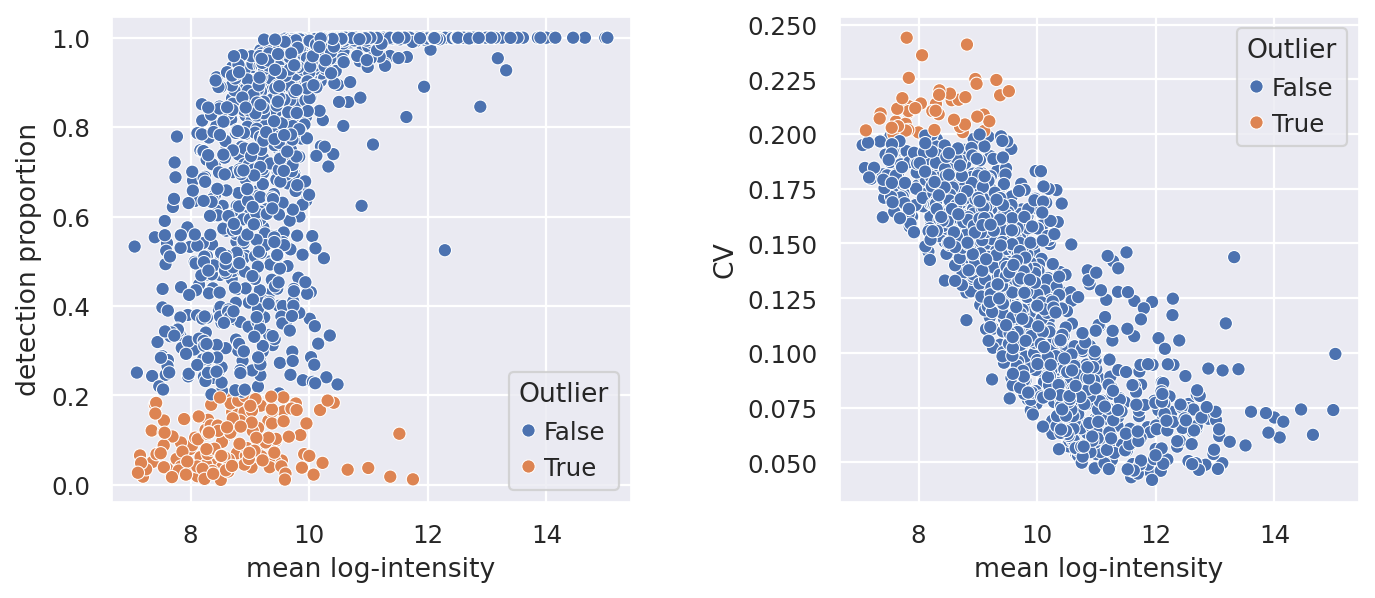

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.4)

ax = axes[0]
sns.scatterplot(data=df, x="mean_abundance", y="detection_rate", ax=ax, hue="detection_outlier")
ax.legend(title="Outlier")
ax.set(xlabel="mean log-intensity", ylabel="detection proportion")

ax = axes[1]
sns.scatterplot(data=df, x="mean_abundance", y="cv", ax=ax, hue="cv_outlier")
ax.set(xlabel="mean log-intensity", ylabel="CV")
ax.legend(title="Outlier")

Let's filter out the proteins with low detection rate and high coefficient of variation.

In [142]:
mask = ~(detection_rate_mask | cv_mask)
adata = adata[:, mask].copy()

## Training


The data contains several technical sources of variance, such as mTRAQ label-biases, LC-batches and biological replicates. Let protVI account for these effects when learning the latent representation.

In [15]:
protvi.model.PROTVI.setup_anndata(
    adata,
    batch_key="label",
    multilevel_cov_key=["celltype"],
    categorical_covariate_keys=["lc_batch", "biorep", "carrier_amount"],
)

In [ ]:
model = protvi.model.PROTVI(
    adata,
    log_variational=False,
    n_hidden=128,
    n_layers=1,
    use_x_mix=False,
    decoder_type="selection",
    x_variance="protein",
    batch_dim=20,
)

Let's train the model.

In [ ]:
model.train(
    max_epochs=5000,
    plan_kwargs={"mechanism_weight": 0.3, "n_epochs_kl_warmup": 50, "kl_weight": 1},
    check_val_every_n_epoch=1,
)

In [ ]:
pl.plot_loss(model.history, epoch_start=180, validation_smooth_window=10)

## Latent embeddings


In [28]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [29]:
adata_latent = sc.AnnData(X=latent, obs=adata.obs)
sc.pp.pca(adata_latent)

In [35]:
sc.pp.neighbors(adata, use_rep="latent", n_neighbors=15)
sc.tl.umap(adata)

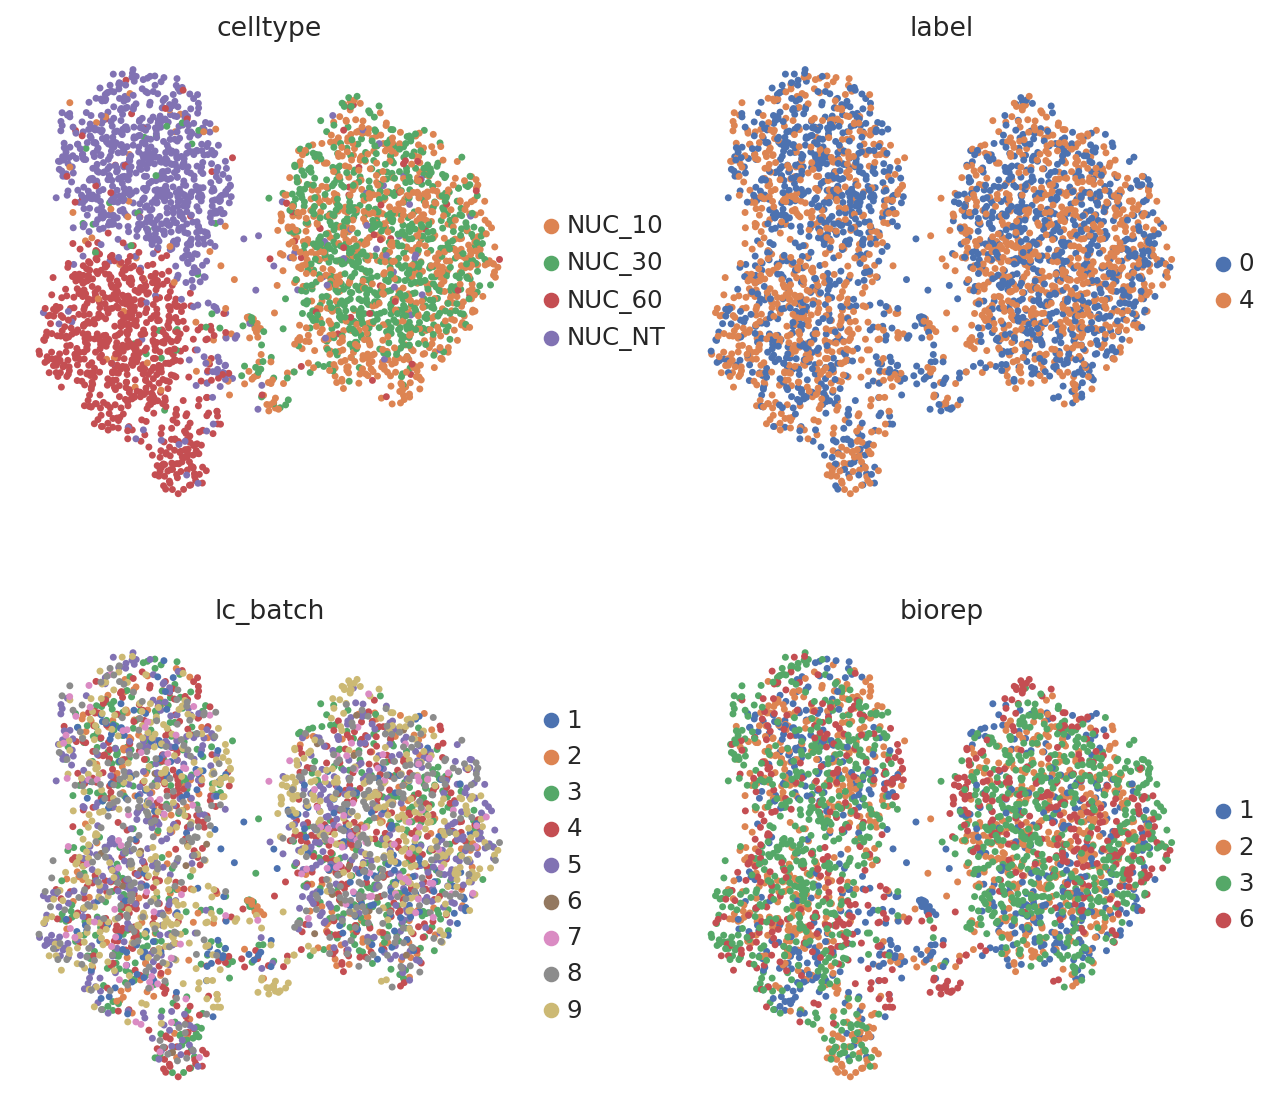

In [36]:
sc.pl.umap(
    adata,
    color=["celltype", "label", "lc_batch", "biorep"],
    vmin="p01",
    vmax="p99",
    ncols=2,
)

## Missing data mechanism

Since MS-based proteomics contains NaN values, imputation of protein abundances is necessary. Let's do this with protVI.

In [ ]:
x_est, p_est = model.impute(adata)

Let's look at the mean imputed abundances and mean probability for detection for each protein.

Text(0.5, 1.0, 'detection probability curves')

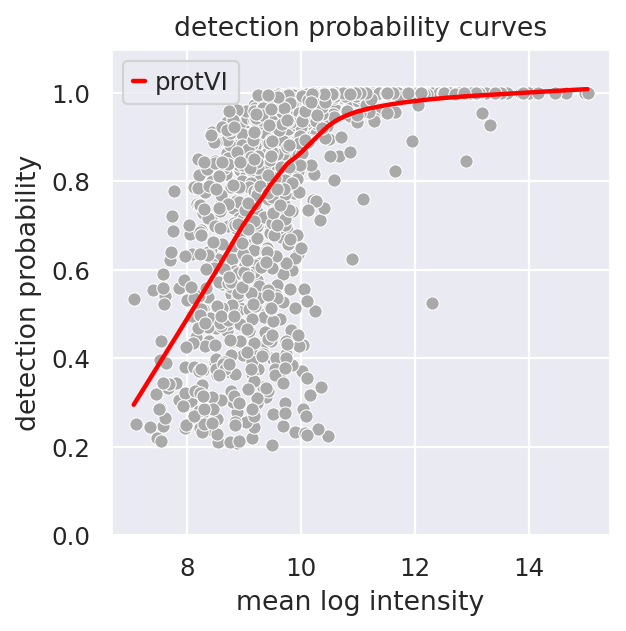

In [65]:
detection_rate = np.mean(p_est, axis=0)
mean_abundance = np.nanmean(adata.layers["raw"], axis=0)

mu_smooth, p_smooth = protvi.utils.smoothing(mean_abundance, detection_rate, lowess_frac=0.3)

x = adata.layers["raw"].copy()

x_protein = np.nanmean(x, axis=0)
p_protein = 1 - np.mean(np.isnan(x), axis=0)
p_est_protein = p_est.mean(axis=0)

fig, ax = plt.subplots(figsize=(4, 4), ncols=1)
ax = sns.scatterplot(x=x_protein, y=p_protein, color="darkgrey")

idx = np.argsort(mu_smooth)
ax.plot(mu_smooth[idx], p_smooth[idx], label="protVI", linewidth=2, color="red")
ax.set_ylim((0.0, 1.1))
ax.legend()
ax.set_xlabel("mean log intensity")
ax.set_ylabel("detection probability")
ax.set_title("detection probability curves")

Looks like protVI is able to capture the trend is between protein abundance and detection probability.

## Comparison


Let's compare the latent representation with other models.

### Normalised and imputed data


In [100]:
X_norm_protvi = model.get_normalized_abundance(
    adata=adata, n_samples=1, return_numpy=True, return_mean=False, batch_size=128
)

adata_protvinorm = sc.AnnData(X=X_norm_protvi, obs=adata.obs)
sc.pp.pca(adata_protvinorm)
adata.obsm["X_pca_protVI-norm"] = adata_protvinorm[adata.obs_names].obsm["X_pca"]
adata.obsm["X_protVI-norm"] = adata_protvinorm.X

x_est, p_est = model.impute(adata=adata)
adata_imp = sc.AnnData(X=x_est, obs=adata.obs, var=adata.var)
sc.pp.pca(adata_imp)
adata.obsm["X_pca_protVI-imp"] = adata_imp.obsm["X_pca"]
adata.obsm["X_protVI-imp"] = adata_imp.X

### KNN-ComBat


In [113]:
imputer = KNNImputer(n_neighbors=5)
features = imputer.fit_transform(adata.layers["raw"].copy())

adata_knn = adata.copy()
adata_knn.X = features

combat_data = adata_knn.copy()
sc.pp.combat(combat_data, key="label", covariates=["celltype"])
features_combat = combat_data.X

sc.pp.pca(combat_data)
adata.obsm["X_knnCombat"] = features_combat

### protVI - ComBat


Let's also compare the imputation performance of protVI with batch correction done in the original paper.

In [114]:
adata_slavov = sc.read("../../data/processed/derks2024_slavovlab_net.h5ad")

In [115]:
combat_data = adata_protvinorm.copy()
sc.pp.combat(combat_data, key="lc_batch")
features_combat = combat_data.X

sc.pp.pca(combat_data)
adata.obsm["X_protVI-impCombat"] = features_combat

In [116]:
adata_slavov.obs_names = adata_slavov.obs_names.str.replace("-", ".").values.copy()
adata_slavov = adata_slavov.copy()
adata_evals = adata.copy()

In [117]:
del adata_evals.obsp
del adata_evals.layers
del adata_evals.varm
del adata_evals.uns

In [118]:
adata_evals = adata_evals[adata_evals.obs_names.isin(adata_slavov.obs_names.tolist())].copy()

In [119]:
adata_slavov = adata_slavov[adata_evals.obs_names, :]

adata_evals.obsm["slavov"] = adata_slavov.X.copy()
adata_evals.obsm["X_pca_slavov"] = adata_slavov.obsm["X_pca"]

In [ ]:
bm = Benchmarker(
    adata_evals,
    batch_key="label",
    label_key="celltype",
    embedding_obsm_keys=[
        "latent",
        "slavov",
        "X_pca_slavov",
        "X_protVI-norm",
        "X_protVI-imp",
        "X_knnCombat",
        "X_protVI-impCombat",
    ],
    n_jobs=3,
)
bm.benchmark()

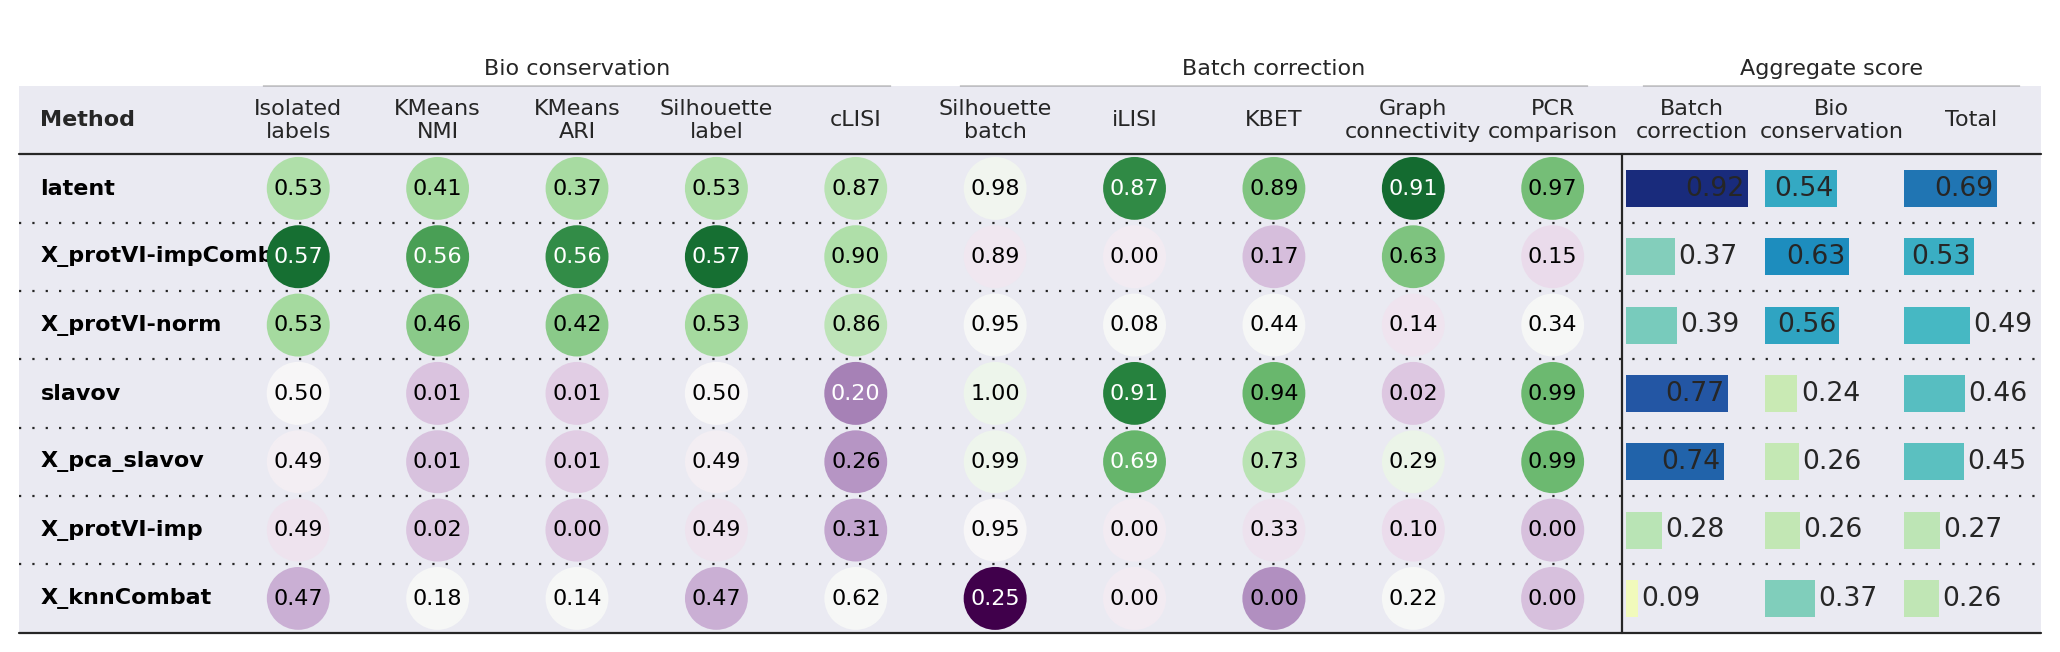

In [121]:
bm.plot_results_table(min_max_scale=False)

protVI is able to correct for batch effects while having high bio conservation.